# ECSN Profile Comparison

In [1]:
from StarKiller.initialization import starkiller_initialize
from StarKiller.interfaces import EosType
from StarKiller.interfaces import BurnType
from StarKiller.eos import Eos
from StarKiller.network import Network
from mesa_reader import MesaData
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Initialize Starkiller Microphysics

In [2]:
probin_file = "probin_ecsn"

In [3]:
starkiller_initialize(probin_file)

In [4]:
helmholtz = Eos()
ecsn = Network()

In [5]:
def evaluate_rhs(burn_state):
    ecsn.rhs(burn_state)
    return burn_state

def evaluate_eos(burn_state):
    eos_state = burn_state.to_eos_type()
    helmholtz.evaluate(eos_state.eos_input_rt, eos_state)
    return eos_state

## Read MESA profile

In [6]:
mesa_data = MesaData("../../../../profiles/ONe6040-final.data")

In [7]:
mesa_enuc = mesa_data.eps_nuc_mc2 - mesa_data.eps_nuc_neu

In [8]:
shared_species = []

for s in ecsn.short_species_names:
    if s in mesa_data.bulk_names:
        shared_species.append(s)

print("Species shared between MESA and Starkiller networks:\n")
for s in shared_species:
    print(s)

Species shared between MESA and Starkiller networks:

h1
he4
o16
o20
f20
ne20
mg24
si28


## Evaluate the Starkiller equivalent of MESA (eps_nuc_mc2 - eps_nuc_neu)

In [9]:
sk_burn_results = []
sk_eos_results = []

for zi in range(len(mesa_data.zone)):
    density = 10.0**mesa_data.logRho[zi]
    temperature = 10.0**mesa_data.logT[zi]
    
    # Set mass fractions for Starkiller network by zeroing
    # mass fractions for species missing in the MESA network and ignoring
    # species missing in the Starkiller network.
    #
    # Then renormalize the Starkiller mass fractions to sum to 1.
    mass_fractions = []
    
    for s in ecsn.short_species_names:
        if s in mesa_data.bulk_names:
            mass_fractions.append(mesa_data.data(s)[zi])
        else:
            mass_fractions.append(0.0)
    
    mass_fractions = np.array(mass_fractions)
    mass_fractions = mass_fractions/np.sum(mass_fractions)
    
    
    burn_state = BurnType()
    burn_state.state.rho = density
    burn_state.state.t = temperature
    burn_state.state.xn = mass_fractions
    
    # Evaluate the RHS and EOS in Starkiller
    sk_burn_results.append(evaluate_rhs(burn_state))
    sk_eos_results.append(evaluate_eos(burn_state))

In [10]:
sk_eps = []

for burn_state in sk_burn_results:
    sk_eps.append(burn_state.state.ydot[ecsn.net_ienuc])
    
sk_eps = np.array(sk_eps)

## Plot MESA and Starkiller energy generation rates

In [11]:
font = {'size': 20}
text = {'usetex': True}

matplotlib.rc('font', **font)
matplotlib.rc('text', **text)

mesa_enuc_pos = np.maximum(mesa_enuc, 0.0)
mesa_enuc_neg = np.maximum(-mesa_enuc, 0.0)

sk_enuc_pos = np.maximum(sk_eps, 0.0)
sk_enuc_neg = np.maximum(-sk_eps, 0.0)

radius_km = mesa_data.radius_cm * 1.0e-5

def plot_enuc(xlim=None, ylim=None):
    fig = plt.figure()
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)

    ax = fig.add_subplot(111)

    ax.plot(radius_km, mesa_enuc_pos, color='b', linestyle='-', 
            label=r'$\mathrm{MESA}$ $\dot{\varepsilon} > 0$')
    
    ax.plot(radius_km, mesa_enuc_neg, color='b', linestyle=':', 
            label=r'$\mathrm{MESA}$ $\dot{\varepsilon} < 0$')

    ax.plot(radius_km, sk_enuc_pos, color='g', linestyle='-', 
            label=r'$\mathrm{StarKiller}$ $\dot{\varepsilon} > 0$')
    
    ax.plot(radius_km, sk_enuc_neg, color='g', linestyle=':', 
            label=r'$\mathrm{StarKiller}$ $\dot{\varepsilon} < 0$')

    ax.set_yscale('log')
    
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(r'$\mathrm{r\ (km)}$')
    ax.set_ylabel(r'$\dot{\varepsilon} = \dot{\varepsilon}_{m c^2} - |\dot{\varepsilon}_{\nu}|$')
    ax.legend(loc='upper right')

    plt.show()

In [12]:
def plot_field(xlim=None, ylim=None, mesa_field="temperature"):
    fig = plt.figure()
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)

    ax = fig.add_subplot(111)

    ax.plot(radius_km, mesa_data.data(mesa_field))

    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(r'$\mathrm{r\ (km)}$')
    ax.set_ylabel(r'$\mathrm{' + '{}'.format(mesa_field) + r'}$')

    plt.show()

### Entire Profile

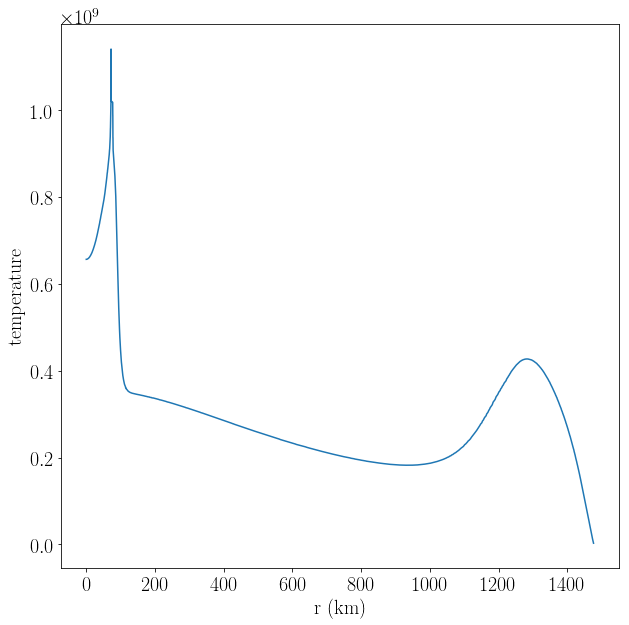

In [13]:
plot_field(mesa_field='temperature')

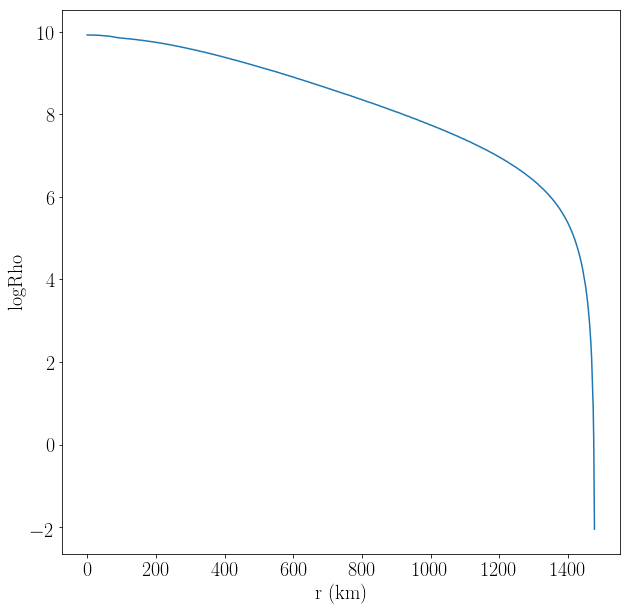

In [14]:
plot_field(mesa_field='logRho')

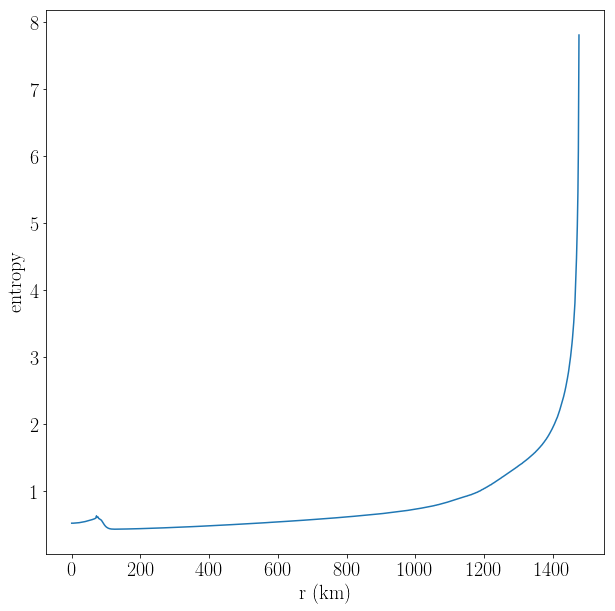

In [15]:
plot_field(mesa_field='entropy')

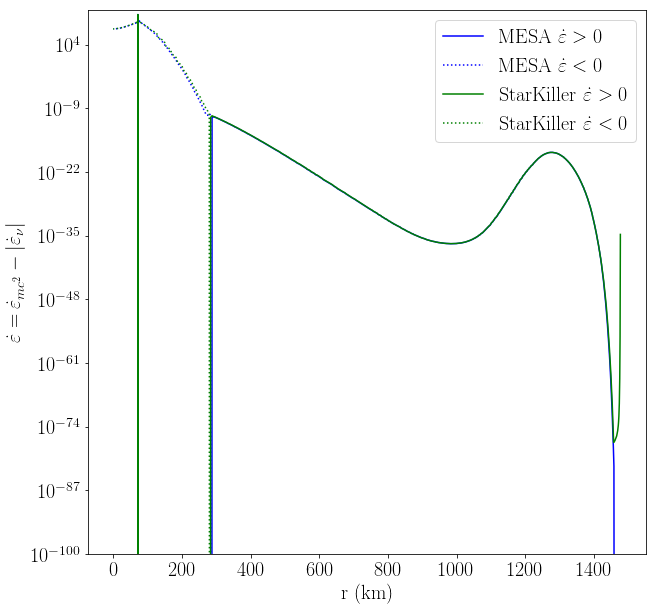

In [16]:
plot_enuc(ylim=[1.0e-100, 1.0e11])

### Zoom in on peak temperature

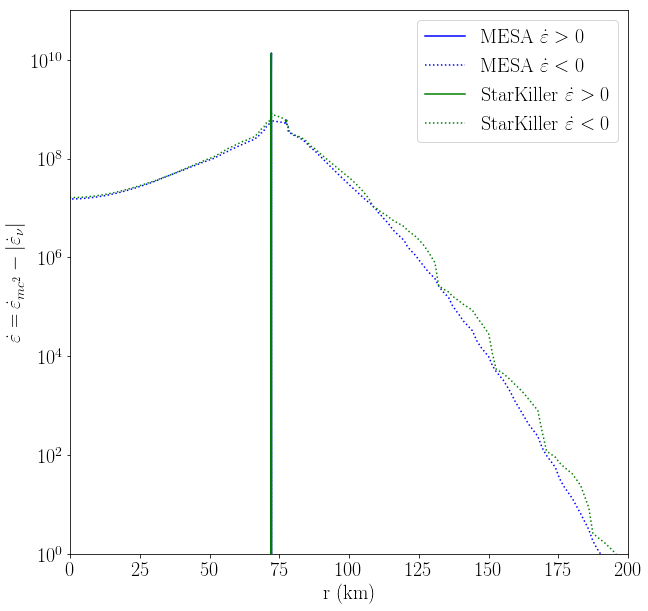

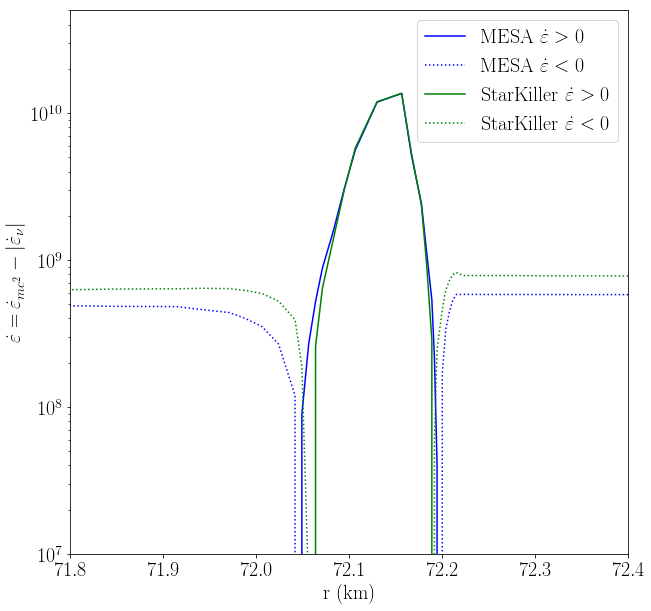

In [17]:
plot_enuc(xlim=[0.0, 200], ylim=[1.0, 1.0e11])
plot_enuc(xlim=[71.8, 72.4], ylim=[1.0e7, 5.0e10])

### Zoom in on ~300 km radius

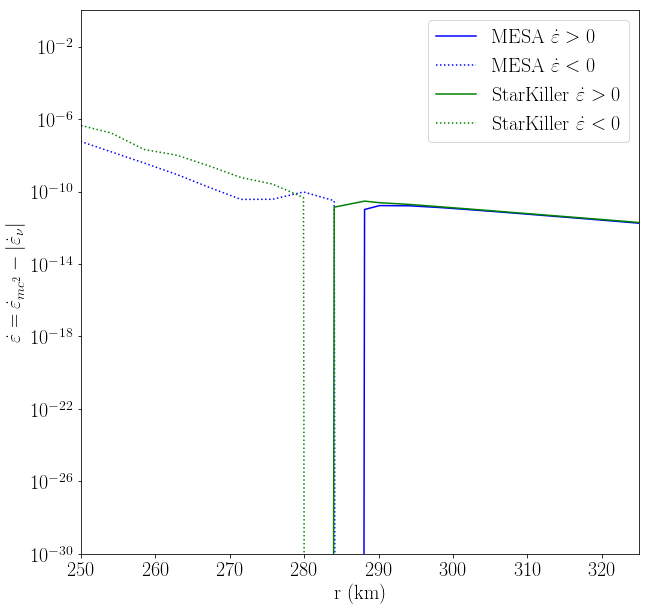

In [18]:
plot_enuc(xlim=[250, 325], ylim=[1.0e-30, 1.0])